# UDS emulator 

## Preliminaries

In [1]:
num_events_training     = 50
num_events_validation   = 5
steps_ahead             = 1

epochs = 40

In [2]:
from my_imports import *

In [3]:
Repository('.').head.shorthand

'No_clipping_with_elevation'

In [4]:
yaml_path = 'config_file.yaml'
yaml_data = utils.load_yaml(yaml_path)

# Directories
training_simulations_path   = yaml_data['training_simulations_path']
validation_simulations_path = yaml_data['validation_simulations_path']

inp_path =  yaml_data['inp_path']

## Create simulation objects from data

In [ ]:
list_of_training_simulations    = os.listdir(training_simulations_path)
list_of_validation_simulations  = os.listdir(validation_simulations_path)

random.shuffle(list_of_training_simulations)

print('Number of training simulations: ', len(list_of_training_simulations))
print('Number of validation simulations: ', len(list_of_validation_simulations))


In [ ]:
# training_simulations = utils.extract_simulations_from_folders(training_simulations_path, inp_path, max_events = num_events_training)

# training_windows = []
# events_to_train= list(range(num_events_training))
# for event in events_to_train:
#     sim = training_simulations[event]
#     training_windows += sim.get_all_windows(steps_ahead = steps_ahead)


In [ ]:
with open('Temporary windows.pk', 'rb') as handle:
    training_windows = pickle.load(handle)

In [ ]:
validation_simulations = utils.extract_simulations_from_folders(validation_simulations_path, inp_path, max_events =num_events_validation)

validation_windows = []
events_to_validate= list(range(num_events_validation))
for event in events_to_validate:
    sim = validation_simulations[event]
    validation_windows += sim.get_all_windows(steps_ahead = steps_ahead)

## Normalizer

In [ ]:
normalizer = Normalizer(training_windows)

In [ ]:
normalized_training_windows = normalizer.get_list_normalized_training_windows()
training_loader = DataLoader(normalized_training_windows, batch_size=32, shuffle = True)

In [ ]:
normalized_validation_windows = [normalizer.normalize_window(val_win) for val_win in validation_windows]
validation_loader = DataLoader(normalized_validation_windows, batch_size=32)

## Training GNN

In [ ]:
gnn_model = GNNModel()
optimizer = optim.Adam(gnn_model.parameters(), lr = 0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss_fn   = nn.MSELoss()

In [ ]:
history = train(
    model = gnn_model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = loss_fn,
    train_dl = training_loader,
    val_dl = validation_loader,
    epochs = epochs,
    device = 'cpu',
    report_freq = 2
    )


## Results

In [ ]:
vis.plot_loss(history)

## Using the metamodel

In [13]:
val_event =  validation_simulations[0]

length = val_event.simulation_length
sim_in_window = val_event.get_all_windows(steps_ahead = 1)[0]
norm_sim_in_window = normalizer.normalize_window(sim_in_window)

name_nodes = norm_sim_in_window.name_nodes

swmm_heads_pd       = utils.tensor_heads_to_normalized_pd(sim_in_window['y'],             normalizer, name_nodes)
predicted_heads_pd  = utils.tensor_heads_to_normalized_pd(gnn_model(norm_sim_in_window),  normalizer, name_nodes)

<AxesSubplot:>

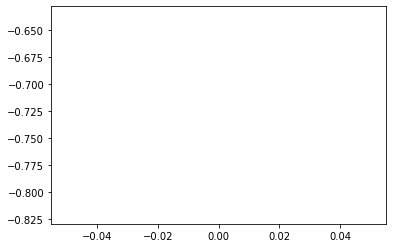

In [14]:
node = name_nodes[24]

swmm_heads_pd[node].plot()
predicted_heads_pd[node].plot()

## Visualization of results

In [15]:
target      = normalizer.unnormalize_heads(norm_sim_in_window.y)
predicted   = normalizer.unnormalize_heads(gnn_model(norm_sim_in_window).detach())

In [ ]:
pd.DataFrame(target[-1,:].numpy()).plot()
pd.DataFrame(predicted[-1,:].numpy()).plot()

In [ ]:
importlib.reload(vis)

In [ ]:
error = torch.abs(target - predicted)
fig = vis.plot_nodal_variable(error, norm_sim_in_window, 'error in head at time: ', colorscale = 'OrRd')


In [ ]:
norm_sim_in_window.name_nodes[0]

In [ ]:
# fig.write_html('error.html')

In [ ]:
fig = vis.plot_nodal_variable(target, norm_sim_in_window, 'Target Head ', colorscale = 'PuBu', ref_marker_size = 2.5)

# Scratchpad

In [ ]:
zero_cases_simulations_path = yaml_data['zero_cases_simulations_path']
list_of_zero_cases_simulations  = os.listdir(zero_cases_simulations_path)

zero_cases_simulations = utils.extract_simulations_from_folders(zero_cases_simulations_path, inp_path, max_events = 2)


In [ ]:
gnn_model = GNNModel()

In [ ]:
sim_trial = zero_cases_simulations[0]

length = sim_trial.simulation_length
sim_in_window = sim_trial.get_all_windows(steps_ahead = length-2)[0]
norm_sim_in_window = normalizer.normalize_window(sim_in_window)

name_nodes = norm_sim_in_window.name_nodes

swmm_heads_pd       = utils.tensor_heads_to_normalized_pd(sim_in_window['y'],             normalizer, name_nodes)
predicted_heads_pd  = utils.tensor_heads_to_normalized_pd(gnn_model(norm_sim_in_window),  normalizer, name_nodes)

In [ ]:
target      = normalizer.unnormalize_heads(norm_sim_in_window.y)
predicted   = normalizer.unnormalize_heads(gnn_model(norm_sim_in_window).detach())

In [ ]:
pd.DataFrame(target[-1,:].numpy()).plot()
pd.DataFrame(predicted[-1,:].numpy()).plot()

In [ ]:
error = torch.abs(target - predicted)
fig = vis.plot_nodal_variable(error, norm_sim_in_window, 'error in head at time: ', colorscale = 'OrRd')

In [ ]:
norm_sim_in_window.name_nodes[0]

In [ ]:
# fig.write_html('error.html')

In [ ]:
fig = vis.plot_nodal_variable(target, norm_sim_in_window, 'Target Head ', colorscale = 'PuBu', ref_marker_size = 2.5)

# Scratchpad

In [ ]:
zero_cases_simulations_path = yaml_data['zero_cases_simulations_path']
list_of_zero_cases_simulations  = os.listdir(zero_cases_simulations_path)

zero_cases_simulations = utils.extract_simulations_from_folders(zero_cases_simulations_path, inp_path, max_events = 2)


In [ ]:
gnn_model = GNNModel()

In [ ]:
sim_trial = zero_cases_simulations[0]

length = sim_trial.simulation_length
sim_in_window = sim_trial.get_all_windows(steps_ahead = length-2)[0]
norm_sim_in_window = normalizer.normalize_window(sim_in_window)

name_nodes = norm_sim_in_window.name_nodes

swmm_heads_pd       = utils.tensor_heads_to_normalized_pd(sim_in_window['y'],             normalizer, name_nodes)
predicted_heads_pd  = utils.tensor_heads_to_normalized_pd(gnn_model(norm_sim_in_window),  normalizer, name_nodes)

In [ ]:
target      = normalizer.unnormalize_heads(norm_sim_in_window.y)
predicted   = normalizer.unnormalize_heads(gnn_model(norm_sim_in_window).detach())

In [ ]:
pd.DataFrame(target[20,:].numpy()).plot()
pd.DataFrame(predicted[20,:].numpy()).plot()

In [ ]:
error = torch.abs(target - predicted)
fig = vis.plot_nodal_variable(error, norm_sim_in_window, 'error in head at time: ', colorscale = 'OrRd')

In [ ]:
fig = vis.plot_nodal_variable(target, norm_sim_in_window, 'Target ', colorscale = 'PuBu', ref_marker_size = 3)

In [ ]:
normalizer.min_h

In [ ]:
val_event =  validation_simulations[0]

length = val_event.simulation_length
sim_in_windows = val_event.get_all_windows(steps_ahead = 1)

In [ ]:
norm_sim_in_windows = [normalizer.normalize_window(i) for i in sim_in_windows]

In [ ]:
results = []
for i in norm_sim_in_windows:
    results.append(gnn_model(i))

In [ ]:
results_tensor = torch.cat(results, axis = 1).detach()

In [ ]:
results_np = results_tensor.numpy()

In [ ]:
pd.Series(results_np[110, :]).plot()